In [2]:
import matplotlib.pyplot as plt
import pandas as pd

tracks = pd.read_csv("fma-rock-vs-hiphop.csv")
echonest_metrics = pd.read_json("echonest-metrics.json", precise_float=True)

print(tracks.columns)
print("------------------")
print(echonest_metrics.columns)
print("------------------")

echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')
echo_tracks.info()

Index(['track_id', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')
------------------
Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   spee

In [3]:
numeric_columns = echo_tracks.select_dtypes(include=['number'])

corr_matrics = numeric_columns.corr()
corr_matrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [4]:
from sklearn.model_selection import train_test_split

features = echo_tracks.drop(['genre_top', 'track_id'], axis=1)
labels = echo_tracks['genre_top']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=12)

In [5]:
from sklearn.preprocessing import StandardScaler
#basically z score normalization
# mean is 0 and standard deviation is 1

scaler = StandardScaler()

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)


Text(0.5, 0, 'Principal Component #')

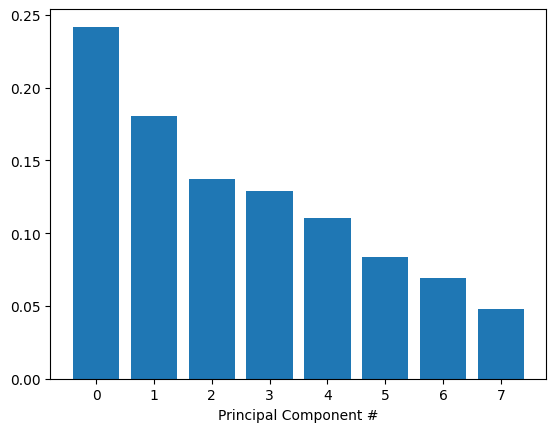

In [6]:
%matplotlib inline
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

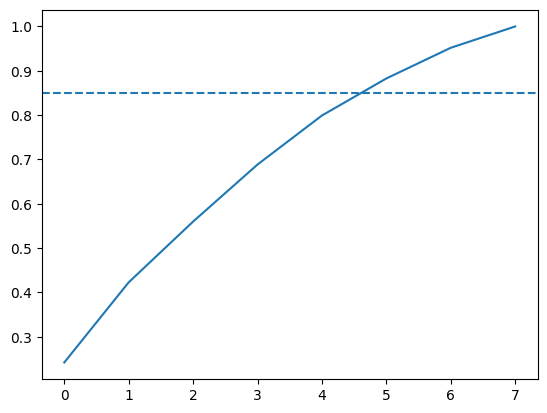

In [7]:
import numpy as np

cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [8]:
pca = PCA(n_components=6)

train_pca = pca.fit_transform(scaled_train_features)
test_pca = pca.transform(scaled_test_features)

In [9]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(random_state=12)
tree.fit(train_pca, train_labels)

pred_labels_tree = tree.predict(test_pca)
print(pred_labels_tree)

['Rock' 'Rock' 'Rock' ... 'Rock' 'Rock' 'Rock']


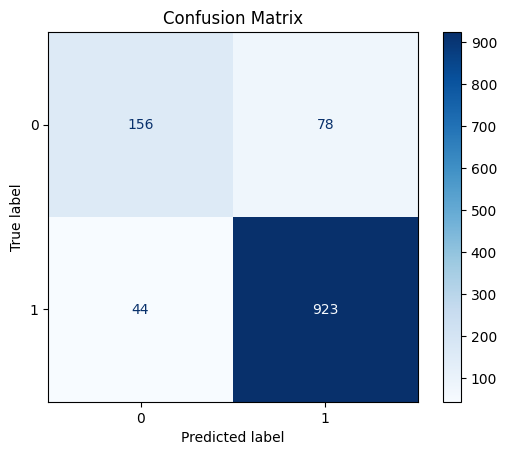

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, pred_labels_tree)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()

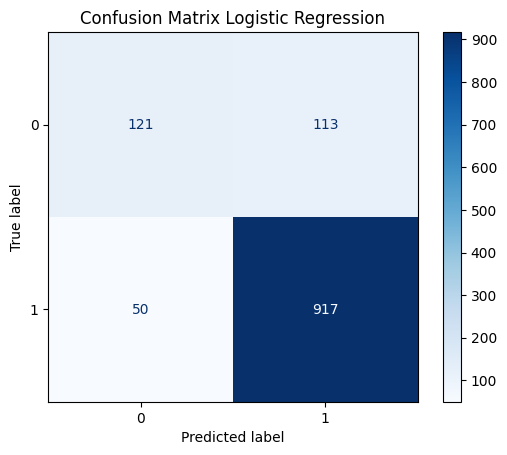

In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=12)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

cm_logit = confusion_matrix(test_labels, pred_labels_logit)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logit)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix Logistic Regression')
plt.show()


In [12]:
from sklearn.metrics import classification_report

class_rep_tree = classification_report(test_labels, pred_labels_tree)
print("Random Forest: \n", class_rep_tree)

class_rep_log = classification_report(test_labels, pred_labels_logit)
print("Logistic Regression: \n", class_rep_log)

Random Forest: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.67      0.72       234
        Rock       0.92      0.95      0.94       967

    accuracy                           0.90      1201
   macro avg       0.85      0.81      0.83      1201
weighted avg       0.89      0.90      0.90      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.71      0.52      0.60       234
        Rock       0.89      0.95      0.92       967

    accuracy                           0.86      1201
   macro avg       0.80      0.73      0.76      1201
weighted avg       0.85      0.86      0.86      1201



In [13]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

rock_only = rock_only.sample(hop_only.shape[0], random_state=12)

rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=12)

scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

pca = PCA()
train_pca = pca.fit_transform(train_features)
test_pca = pca.transform(test_features)

tree = RandomForestClassifier(random_state=12)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)



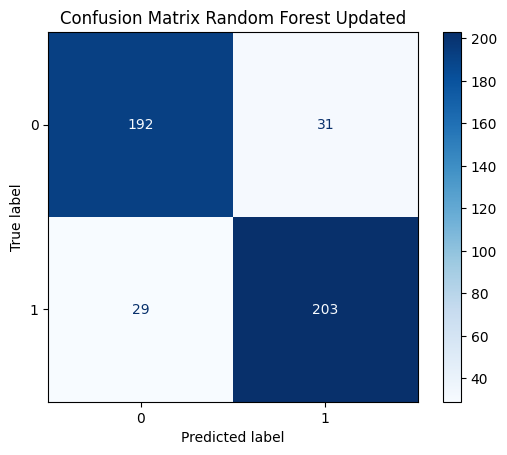

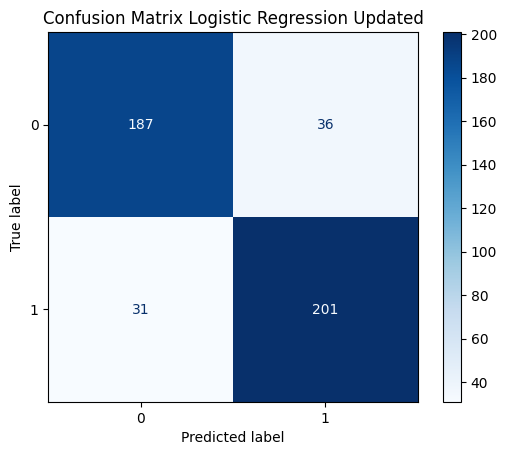

In [14]:
tree = RandomForestClassifier(random_state=12)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

logreg = LogisticRegression(random_state=12)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

cm_tree_updated = confusion_matrix(test_labels, pred_labels_tree)
cm_logit_updated = confusion_matrix(test_labels, pred_labels_logit)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree_updated)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix Random Forest Updated')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_logit_updated)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix Logistic Regression Updated')
plt.show()

In [17]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

tree_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=6)), ('tree', RandomForestClassifier(random_state=12))])
logreg_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=6)), ('logreg', LogisticRegression(random_state=12))])

kf = KFold(10)

tree_scores = cross_val_score(tree_pipe, features, labels, cv=kf)
logreg_scores = cross_val_score(logreg_pipe, features, labels, cv=kf)

print('Random Forest:', np.mean(tree_scores))
print('Logistic Regression:', np.mean(logreg_scores))


Random Forest: 0.7950549450549451
Logistic Regression: 0.7686813186813186


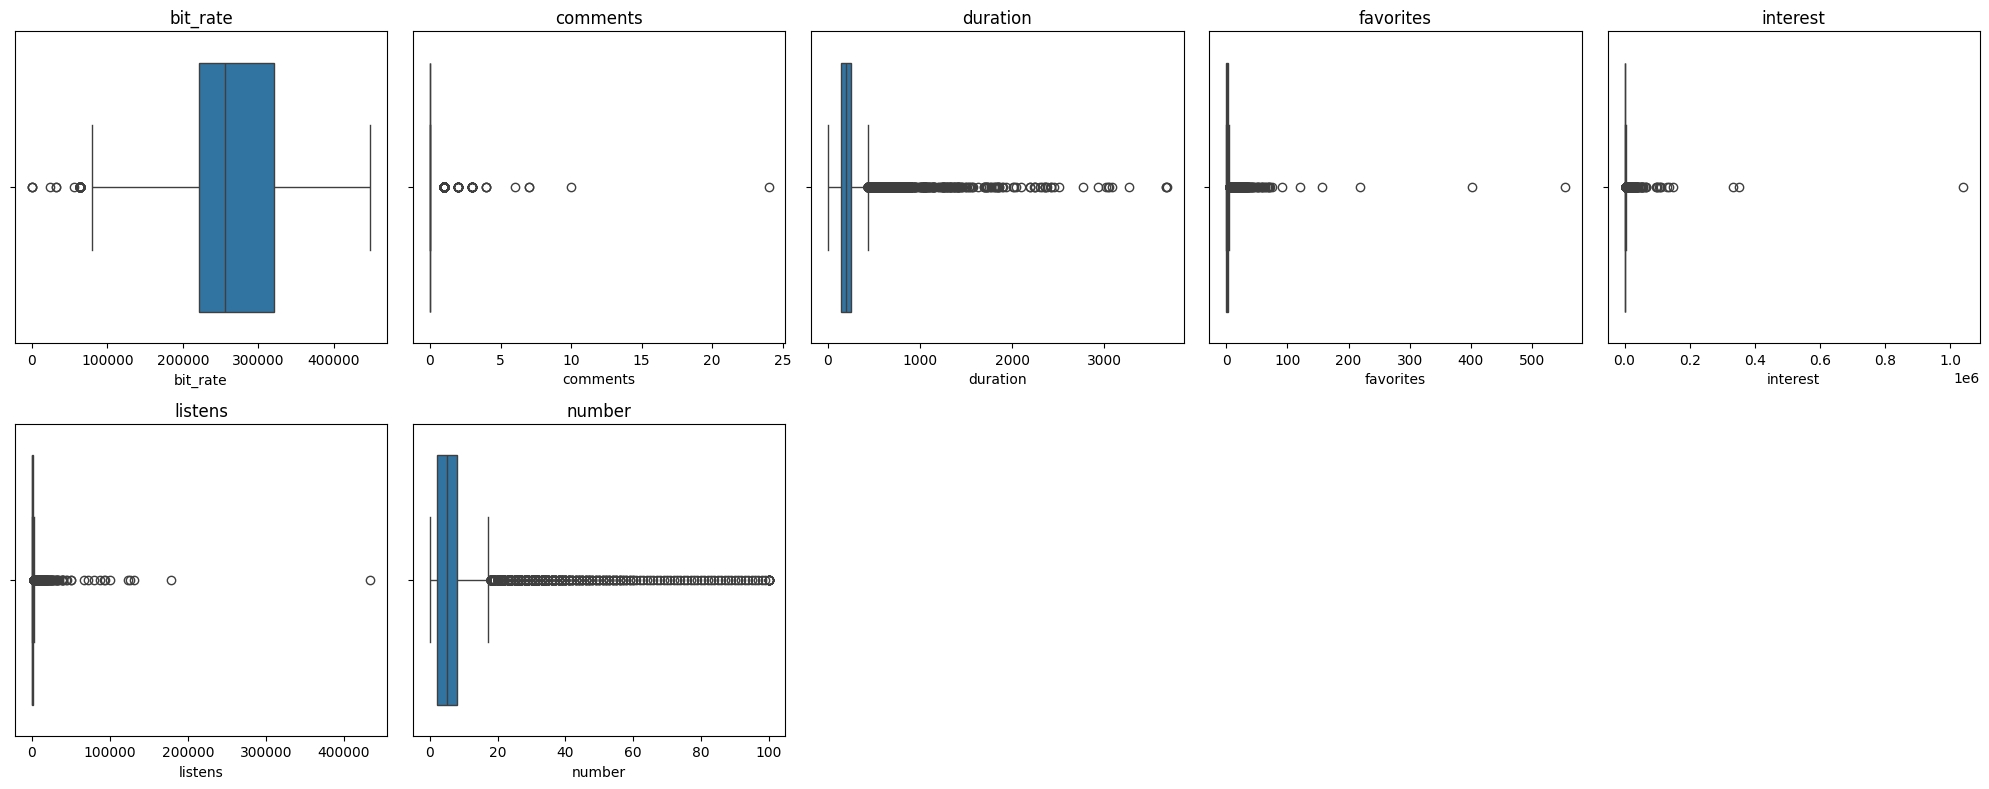

In [21]:
import seaborn as sns

df = pd.read_csv('fma-rock-vs-hiphop.csv')

numeric_features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['track_id'])
num_features = len(numeric_features.columns)
num_cols = 5
num_rows = int(np.ceil(num_features/num_cols))

plt.figure(figsize=(num_cols * 4, num_rows * 4))

for i, columns in enumerate(numeric_features.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(x=numeric_features[columns])
    plt.title(columns)
    plt.tight_layout()


